In [2]:
#Dependencies
import pandas as pd
import numpy as np
from scipy.sparse.linalg import svds
from sklearn.model_selection import train_test_split
import tensorflow as tf
from torch.utils.data import DataLoader
import itertools
import torch

import os

import pandas as pd
import numpy as np

from scipy.sparse import csr_matrix

from implicit.als import AlternatingLeastSquares
                                                            
import os 

from collections import defaultdict
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
#from torchtools.optim import Ranger
from ranger import Ranger

import tqdm
import random
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity as cs
import seaborn as sns

## 1. 데이터 불러오기

In [3]:
            datapath = '../data/data_final.csv'
columns =  ['item', 'user', 'rating', 'timestamp']
df = pd.read_csv(datapath, sep = ",", names = columns, dtype = int)
df.astype(int)
df.head()

,item,user,rating,timestamp
0,122,3094405,5,1112140800
1,122,14877871,5,1466380800
2,122,7151803,5,1436400000
3,122,10069097,5,1383436800
4,122,13327705,5,1357084800


In [4]:
users_df = df.sort_values(["user","timestamp"]).set_index("user").fillna(0).drop("timestamp",axis=1)
users = dict(tuple(df.groupby("user")))

In [5]:
print(df.shape)

(13361842, 4)


In [6]:
df['user'].nunique()

258582

In [7]:
df['item'].nunique()

637911

In [8]:
# 고유한 유저, 아티스트를 찾아내는 코드
user_unique = df['user'].unique()
item_unique = df['item'].unique()

# 유저, 아티스트 indexing 하는 코드 idx는 index의 약자입니다.
user_to_idx = {v:k for k,v in enumerate(user_unique)}
idx_to_user = {k:v for k,v in enumerate(user_unique)}
item_to_idx = {v:k for k,v in enumerate(item_unique)}
idx_to_item = {k:v for k,v in enumerate(item_unique)}

In [9]:
# indexing을 통해 데이터 컬럼 내 값을 바꾸는 코드
# dictionary 자료형의 get 함수는 https://wikidocs.net/16 을 참고하세요.

# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 
temp_user_data = df['user'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(df):   # 모든 row가 정상적으로 인덱싱되었다면
    print('userId column indexing OK!!')
    df['user'] = temp_user_data   # data['userId']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('userId column indexing Fail!!')

# movie_to_idx을 통해 artist 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_item_data = df['item'].map(item_to_idx.get).dropna()
if len(temp_item_data) == len(df):
    print('itemId column indexing OK!!')
    df['item'] = temp_item_data
else:
    print('itemId column indexing Fail!!')
# up_data

userId column indexing OK!!
itemId column indexing OK!!


In [10]:
num_user = df['user'].nunique()
num_item = df['item'].nunique()

csr_data = csr_matrix((df['rating'], (df.user, df.item)), shape= (num_user, num_item))

In [11]:
#num_threads=-1
als_model = AlternatingLeastSquares(factors=100, regularization=0.01,use_gpu=False,
                                    iterations=15,dtype=np.float32,calculate_training_loss=True, num_threads=1)

#item x user
csr_data_transpose = csr_data.T
# csr_data_transpose
als_model.fit(csr_data_transpose)

In [12]:
item_embeddings_dict = {idx_to_item[i]:tf.convert_to_tensor(als_model.item_factors[i]) for i in tqdm.tqdm(range(num_item))}
user_embeddings_dict = {idx_to_user[i]:tf.convert_to_tensor(als_model.user_factors[i]) for i in tqdm.tqdm(range(num_user))}

len(user_embeddings_dict)

100%|██████████| 258582/258582 [00:01<00:00, 133910.81it/s]


258582

In [13]:
len(item_embeddings_dict)

637911

## 2. Train and Test Dataset

In [14]:
#Getting users with positive rating count greater than 10 
# 10 == 'N' positively interacted items
# from collections import defaultdict
# from collections import Counter
users_dict = defaultdict(dict)
users_id_list = set()
for user_id in users:
    rating_freq = Counter(users[user_id]["rating"].values)
    if rating_freq[4]+rating_freq[5]<10 :
        continue    
    else:
        users_id_list.add(int(user_id))
        users_dict[user_id]["item"] = users[user_id]["item"].values
        users_dict[user_id]["rating"] = users[user_id]["rating"].values

In [15]:
users_dict[14680070]["rating"]

array([5, 1, 2, 2, 2, 4, 4, 3, 4, 3, 5, 5, 3, 4, 5, 4, 5, 5, 4, 2, 1, 2,
       2, 2, 4, 5, 4, 1, 2, 4, 4, 3, 5, 4, 4, 5, 5, 1, 5])

In [16]:
users_id_list = np.array(list(users_id_list))
print(users_id_list)

[12058627 14680070  7340040 ...  9437172 12058615 11010043]


In [17]:
print(users_dict[12058627])

{'item': array([  28067,   41744,   81990,   94755,   95277,  104841,  122183,
        177661,  180581,  183115,  211122,  233553,  271914,  284884,
        286968,  300146,  339862,  343635,  364176,  364388,  364375,
        411644,  445202,  463239,  512989,  632956,  723559,  755129,
        809664,  819077,  819739,  878301,  951090, 1009123, 1010557,
       1042421, 1071233, 1107949, 1112160, 1125199, 1341839, 1347405,
       1487939, 1514645, 1580541, 1928572, 1956531, 1956306, 1962144,
       1972774, 1983891, 2009311, 2015798, 2031750, 2098284, 2127133,
       2233093, 2285383, 2295964, 2295969, 2295970, 2301303, 2305905,
       2388411, 2390438, 2542197,  527007, 2791251,  180670,  199910,
        271858,  293239,  441781,  538337,  544191,  766746,  955067,
        962416, 1010621, 1025036, 1151374, 1181909, 1889954, 2108769]), 'rating': array([4, 5, 4, 4, 5, 5, 3, 4, 5, 4, 5, 3, 5, 5, 5, 5, 5, 5, 5, 4, 1, 5,
       5, 5, 4, 5, 5, 5, 1, 4, 5, 5, 5, 4, 5, 4, 5, 2, 5, 5, 4, 5,

In [16]:
len(users_id_list)

254330

In [18]:
#choosing default train_test_split of 25%
train_users,test_users = train_test_split(users_id_list)
print(train_users[:2])

[ 7385348 13470479]


In [18]:
print(test_users[:2])

[12923592 10435973]


In [19]:
from torch.utils.data import Dataset
class UserDataset(Dataset):
    def __init__(self,users_list,users_dict):
        self.users_list = users_list
        self.users_dict = users_dict

    def __len__(self):
        return len(self.users_list)

    def __getitem__(self,idx):
        user_id = self.users_list[idx]
        items = [('1',)]*10
        ratings = [('0',)]*10
        j=0
        for i,rate in enumerate(self.users_dict[user_id]["rating"]):
            if int(rate) >3 and j < 10:
                items[j] = self.users_dict[user_id]["item"][i]
                ratings[j] = self.users_dict[user_id]["rating"][i]
                j += 1
        # item = list(self.users_dict[user_id]["item"][:])
        # rating = list(self.users_dict[user_id]["rating"][:])
        size = len(items)
    
        return {'item':items,'rating':ratings,'size':size,'userid':user_id,'idx':idx}

In [20]:
train_users_dataset = UserDataset(train_users,users_dict)
test_users_dataset = UserDataset(test_users,users_dict)

In [21]:
train_dataloader = DataLoader(train_users_dataset, batch_size=1)
test_dataloader = DataLoader(test_users_dataset, batch_size=1)

In [36]:
train_num = len(train_dataloader)
print(train_num)

190747


In [37]:
test_num = len(test_dataloader)
print(test_num)

63583


## 3. State Representation Models¶

### DDR-ave

In [38]:
''' input
    # dataloader에서 나온 return들
    # user_idb : 해당 user의 id 
    # itemb : 유저가 rating 한 item id 10개(tensor))
    # memory :  유저가 rating 한 item들 list 크기는 유저 * 10(item)  
    idx : user_list에서 user의 index
    output
    state : #state tensor shape [21,100]
'''
def drrave_state_rep(userid_b,items,memory,idx):
    user_num = idx
    H = [] #item embeddings
    user_n_items = items
    user_embeddings = torch.Tensor(np.array(user_embeddings_dict[int(userid_b[0])]),).unsqueeze(0)
    for i,item in enumerate(user_n_items):
        H.append(np.array(item_embeddings_dict[int(item[0])]))
    avg_layer = nn.AvgPool1d(1)  # pooling layer 사용 
    item_embeddings = avg_layer(torch.Tensor(H,).unsqueeze(0)).permute(0,2,1).squeeze(0)
    #print('item_embedding.size: ', item_embeddings.size())
    #print('item_embedding_no permute: ', item_embeddings)
    #print('item_embedding_no permute_T: ', item_embeddings.T)
    #item_embeddings_permute = avg_layer(torch.Tensor(H,).unsqueeze(0)).permute(0,2,1).squeeze(0)
    #print('item_embedding_permute: ', item_embeddings)
    #print('item_embedding.size: ', item_embeddings.size()) 
    #print(item_embeddings)
    #assert (item_embeddings == item_embeddings_permute.T).any()
    state = torch.cat([user_embeddings,user_embeddings*item_embeddings.T,item_embeddings.T])
    #print('state.size: ', state.size())
    #print('user_embedding.size: ', user_embeddings.size())
    # permute => transpose
    return state #state tensor shape [21,100]

### DRR-u

In [39]:
# def drru_state_rep(userid_b,items,memory,idx):
#     user_num = idx
#     H = []
#     user_n_items = items
#     user_embeddings = user_embeddings_dict[userid_b[0]]
#     for i,item in enumerate(user_n_items):
#         ui = np.array(user_embeddings) * np.array(movie_embeddings_dict[item[0]])
#         H.append(ui)

#     pairs = list(itertools.combinations(memory[user_num], 2))
#     for item1,item2 in pairs:
#         pair1 =  np.array(movie_embeddings_dict[str(int(item1))])
#         pair2 = np.array(movie_embeddings_dict[str(int(item2))])

#         product = pair1*pair2
#         H.append(product)
#     state = torch.Tensor(H,)
#     return state #state tensor shape [55,100]


### DRR-p

In [40]:
# def drrp_state_rep(items,memory,idx):
#   user_num = idx
#   H = []
#   user_n_items = items
#   for i,item in enumerate(user_n_items):
#     H.append(np.array(movie_embeddings_dict[item[0]]))
  
#   pairs = list(itertools.combinations(memory[user_num], 2))
#   for item1,item2 in pairs:
#     pair1 =  np.array(movie_embeddings_dict[str(int(item1))])
#     pair2 = np.array(movie_embeddings_dict[str(int(item2))])
#     product = pair1*pair2
#     H.append(product)
#   state = torch.Tensor(H,)
#   return state

### state-rep

In [41]:
# just n items and their embeddings used to represent state
'''
def state_rep(item_b):
    state = []
    user_embeddings = np.zeros((len(columns),100))
    item_ids = list(item[0] for item in item_b)
    for i,subitem in enumerate(user_embeddings):
        if idx_to_id[i] in item_ids:
            user_embeddings[i] = np.array(item_embeddings_dict[idx_to_id[i]])
        else:
            user_embeddings[i] = np.zeros((100,))
    state = torch.Tensor(user_embeddings,)
    return torch.reshape(state,[-1]) 
'''

'\ndef state_rep(item_b):\n    state = []\n    user_embeddings = np.zeros((len(columns),100))\n    item_ids = list(item[0] for item in item_b)\n    for i,subitem in enumerate(user_embeddings):\n        if idx_to_id[i] in item_ids:\n            user_embeddings[i] = np.array(item_embeddings_dict[idx_to_id[i]])\n        else:\n            user_embeddings[i] = np.zeros((100,))\n    state = torch.Tensor(user_embeddings,)\n    return torch.reshape(state,[-1]) \n'

## 4. Actor, Critic 

In [28]:
!pip install git+https://github.com/pabloppp/pytorch-tools@0.2.4 -U

  Cloning https://github.com/pabloppp/pytorch-tools (to revision 0.2.4) to /tmp/pip-req-build-v0gc1bg4
  Created wheel for torchtools: filename=torchtools-0.2.4-py3-none-any.whl size=19202 sha256=bf26534ca7e68846ce89152fbbe4e0ccfd3119fa7b2ffc01828cddbad47e77d6
  Stored in directory: /tmp/pip-ephem-wheel-cache-a4afegj3/wheels/e9/db/08/ceb66f88d5c31d39af6901601b4b9084b365c3b484105ee2f5
Successfully built torchtools
  Attempting uninstall: torchtools
    Found existing installation: torchtools 0.2.4
    Uninstalling torchtools-0.2.4:
      Successfully uninstalled torchtools-0.2.4
You should consider upgrading via the '/home/aiffel0042/anaconda3/envs/aiffel/bin/python3 -m pip install --upgrade pip' command.


In [42]:
#Actor Model:
#Generating an action a based on state s

# Input_dim 5500, output_dim 100, hidden_dim 256 for drr-u, p
# Input_dim 2100, output_dim 100, hidden_dim 256 for drr-ave

# embedding을 normalize(-1, 1) => tanh
# embedding을 standard scaling => PCA whitening

class Actor(torch.nn.Module):
    def __init__(self, input_dim, output_dim,hidden_dim):
        super(Actor, self).__init__()

        self.drop_layer = nn.Dropout(p=0.5)        
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, state):
        x = F.relu(self.linear1(state.to(device)))
        # print(x.shape)
        x = self.drop_layer(x)
        x = F.relu(self.linear2(x))
        # print(x.shape)
        x = self.drop_layer(x)
        # x = torch.tanh(self.linear3(x)) # in case embeds are -1 1 normalized
        x = self.linear3(x) # in case embeds are standard scaled / wiped using PCA whitening
        # return state, x
        return x # state = self.state_rep(state)
   

In [43]:
class Critic(nn.Module):
    def __init__(self,input_dim,output_dim,hidden_dim):

        super(Critic, self).__init__()
        
        self.drop_layer = nn.Dropout(p=0.5)
    
        self.linear1 = nn.Linear(input_dim + output_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)

    def forward(self,state,action):    
        x = torch.cat([state.to(device), action.to(device)], 1)
        # print(x.shape)
        x = F.relu(self.linear1(x))
        x = self.drop_layer(x)
        x = F.relu(self.linear2(x))
        x = self.drop_layer(x)
        x = self.linear3(x)
        return x

In [44]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        #self.buffer = [0 for _ in range(capacity)]
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        # print(batch)
        '''
        zip:
        (s1, a1, r1, ns1) (s2, a2, r2, ns2) (s3, a3, r3, ns3)
        => (s1, s2, s3), (a1, a2, a3), (r1, r2, r3)
        '''
        state, action, reward, next_state = map(np.stack,zip(*batch))
        return state, action, reward, next_state
    
    def __len__(self):
        return len(self.buffer)

In [45]:
'''
state = drrave_state_rep(userid_b,item_b,memory,idx_b)
state_rep =  torch.reshape(state,[-1])
next_state = drrave_state_rep(userid_b,item_b,memory,idx_b)
next_state_rep = torch.reshape(next_state,[-1])
#R.push(state_rep.detach().cpu().numpy(), action_emb.detach().cpu().numpy(), reward, next_state_rep.detach().cpu().numpy()
)
'''

'\nstate = drrave_state_rep(userid_b,item_b,memory,idx_b)\nstate_rep =  torch.reshape(state,[-1])\nnext_state = drrave_state_rep(userid_b,item_b,memory,idx_b)\nnext_state_rep = torch.reshape(next_state,[-1])\n#R.push(state_rep.detach().cpu().numpy(), action_emb.detach().cpu().numpy(), reward, next_state_rep.detach().cpu().numpy()\n)\n'

In [171]:
torch.cuda.is_available()

True

In [46]:
# device = 'cpu'
device = torch.device('cuda')

In [47]:
#used for plotting purposes
p_loss = []
v_loss = []

In [48]:
def ddpg_update(batch_size=1, 
                gamma = 0.6,
                min_value=-np.inf,
                max_value=np.inf,
                soft_tau=1e-2):
    
    state, action, reward, next_state = replay_buffer.sample(batch_size)
    state      = torch.FloatTensor(state).to(device)

    next_state = torch.FloatTensor(next_state).to(device)

    action     = torch.FloatTensor(action).to(device)
    reward     = torch.FloatTensor(reward).to(device)
    # print(state.shape)
    # print(policy_net(state).shape)
    policy_loss = value_net(state, policy_net(state))
    policy_loss = -policy_loss.mean()
    p_loss.append(policy_loss)
    next_action    = target_policy_net(next_state)
    target_value   = target_value_net(next_state, next_action.detach())
    expected_value = reward + gamma * target_value
    expected_value = torch.clamp(expected_value, min_value, max_value)

    value = value_net(state, action)
    # print("1")
    value_loss = value_criterion(value, expected_value.detach())
    # print("2")
    v_loss.append(value_loss)
    policy_optimizer.zero_grad()
    # print("3")
    policy_loss.backward()
    policy_optimizer.step()

    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()

    for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
                target_param.data.copy_(
                    target_param.data * (1.0 - soft_tau) + param.data * soft_tau
                )

    for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )

In [159]:
# #initializing actor and critic networks for drru and drrp state representation

# value_net = Critic(5500,100,256).to(device)
# policy_net = Actor(5500,100,256).to(device)

# target_value_net = Critic(5500,100,256).to(device)
# target_policy_net = Actor(5500,100,256).to(device)

    
# target_policy_net.eval()
# target_value_net.eval()

# for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
#     target_param.data.copy_(param.data)

# for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
#     target_param.data.copy_(param.data)

# value_criterion = nn.MSELoss()
# value_optimizer      = Ranger(value_net.parameters(),  lr=1e-4)
# policy_optimizer     = Ranger(policy_net.parameters(), lr=1e-4)

In [49]:
#initializing for drrave state representation

value_net = Critic(2100,100,256).to(device)
policy_net = Actor(2100,100,256).to(device)

target_value_net = Critic(2100,100,256).to(device)
target_policy_net = Actor(2100,100,256).to(device)


target_policy_net.eval()
target_value_net.eval()

for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
    target_param.data.copy_(param.data)

for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
    target_param.data.copy_(param.data)

value_criterion = nn.MSELoss()
value_optimizer      = Ranger(value_net.parameters(),  lr=1e-4)
policy_optimizer     = Ranger(policy_net.parameters(), lr=1e-4)

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers
Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


In [161]:
print(policy_net)

Actor(
  (drop_layer): Dropout(p=0.5, inplace=False)
  (linear1): Linear(in_features=2100, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=100, bias=True)
)


In [31]:
replay_buffer_size = 10000
replay_buffer = ReplayBuffer(replay_buffer_size)

memory = np.ones((train_num,10))*-1

NameError: name 'train_num' is not defined

In [141]:
print(int(userid_b))

10990777


In [142]:
print(int(userid_b[0]))

10990777


In [50]:
def get_action(state,action_emb,userid_b,item_b,preds):
    action_emb = torch.reshape(action_emb,[1,100]).unsqueeze(0).to(device)
    item_embedding = []
    for item in users_dict[int(userid_b[0])]["item"]:  
        item_embedding.append(np.array(item_embeddings_dict[item]))
    item_embedding = torch.Tensor(item_embedding,)
    items = item_embedding.T.unsqueeze(0).to(device)
    m = torch.bmm(action_emb,items).squeeze(0)  #torch.bmm : batch 행렬 곱연산
    sorted_m,indices = torch.sort(m,descending=True)
    index_list = list(indices[0])
    for i in index_list:
        if users_dict[int(userid_b[0])]["item"][i] not in preds:    
            preds.add(users_dict[int(userid_b[0])]["item"][i])
            return int(i)

In [51]:
def update_memory(memory,action,idx):
    memory[idx] = list(memory[idx,1:])+[action]

In [52]:
rate = 0

In [146]:
it = iter(train_dataloader)
first = next(it)
item_b,rating_b,size_b,userid_b,idx_b = first['item'],first['rating'],first['size'],first['userid'],first['idx']
print(item_b)

[tensor([21786]), tensor([39725]), tensor([70276]), tensor([214354]), tensor([99133]), tensor([242976]), tensor([262049]), tensor([293522]), tensor([649985]), tensor([670284])]


In [147]:
first = next(it)
item_b,rating_b,size_b,userid_b,idx_b = first['item'],first['rating'],first['size'],first['userid'],first['idx']
print(item_b)

[tensor([38869]), tensor([39474]), tensor([204698]), tensor([258484]), tensor([326002]), tensor([325873]), tensor([326313]), tensor([328628]), tensor([328956]), tensor([442795])]


In [148]:
first['rating']

[tensor([5]),
 tensor([5]),
 tensor([5]),
 tensor([5]),
 tensor([5]),
 tensor([5]),
 tensor([5]),
 tensor([5]),
 tensor([5]),
 tensor([5])]

In [149]:
print(int(userid_b[0]))

6717064


In [165]:
memory = np.ones((train_num,10))*-1
drrave_state_rep(userid_b,item_b,memory,idx_b)

tensor([[-5.1019e-03,  1.8949e-02, -6.7247e-04,  ...,  1.5460e-03,
         -5.4347e-03, -1.5698e-02],
        [-1.2878e-04,  4.0399e-04,  8.6758e-06,  ...,  1.2162e-05,
         -8.6169e-06,  3.9995e-05],
        [-1.9765e-03,  7.8490e-03,  1.3121e-04,  ...,  2.7631e-04,
         -1.7703e-03,  3.6182e-03],
        ...,
        [ 1.1743e-01,  1.7994e-01,  3.7203e-02,  ...,  2.0267e-02,
          8.6662e-02,  1.4492e-01],
        [ 8.2598e-03,  9.3675e-03,  9.7267e-03,  ...,  1.1377e-02,
         -1.5253e-02,  2.3575e-02],
        [ 1.2339e-01,  1.4494e-01,  5.7883e-02,  ...,  8.2417e-02,
         -3.0751e-02,  7.4000e-02]])

In [151]:
print(item_b[1])

tensor([39474])


In [54]:
memory = np.ones((train_num,10))*-1
# memory[idx_b] = [item[0] for item in item_b]
# print(memory[idx_b])

In [153]:
print(item_b[1][0])

tensor(39474)


In [154]:
print(memory)

[[-1.00000e+00 -1.00000e+00 -1.00000e+00 ... -1.00000e+00 -1.00000e+00
  -1.00000e+00]
 [ 3.88690e+04  3.94740e+04  2.04698e+05 ...  3.28628e+05  3.28956e+05
   4.42795e+05]
 [-1.00000e+00 -1.00000e+00 -1.00000e+00 ... -1.00000e+00 -1.00000e+00
  -1.00000e+00]
 ...
 [-1.00000e+00 -1.00000e+00 -1.00000e+00 ... -1.00000e+00 -1.00000e+00
  -1.00000e+00]
 [-1.00000e+00 -1.00000e+00 -1.00000e+00 ... -1.00000e+00 -1.00000e+00
  -1.00000e+00]
 [-1.00000e+00 -1.00000e+00 -1.00000e+00 ... -1.00000e+00 -1.00000e+00
  -1.00000e+00]]


In [155]:
print(idx_b)

tensor([1])


## 5. Training

In [ ]:
preddict = dict()
it = iter(train_dataloader)
reward_li = []
for episode in tqdm.tqdm(range(train_num-1)):
    ep_reward = 0
    batch_size= 16
    preds = set()
    #### Env : reset
    first = next(it)
    item_b,rating_b,size_b,userid_b,idx_b = first['item'],first['rating'],first['size'],first['userid'],first['idx']
    memory[idx_b] = [item[0] for item in item_b]
    state = drrave_state_rep(userid_b,item_b,memory,idx_b)
    ######
    for j in range(5):    
        state_rep =  torch.reshape(state,[-1])
        action_emb = policy_net(state_rep)
        action = get_action(state,action_emb,userid_b,item_b,preds)
        ### Env : step
        rate = int(users_dict[int(userid_b[0])]["rating"][action])
        try:
            ratings = (int(rate)-3)/2
        except:
            ratings = 0
        reward = torch.Tensor((ratings,))
        ep_reward = ep_reward + ratings

        if reward > 0:
            update_memory(memory,int(users_dict[int(userid_b[0])]["item"][action]), idx_b)

        next_state = drrave_state_rep(userid_b,item_b,memory,idx_b)
        next_state_rep = torch.reshape(next_state,[-1])
        ######
        replay_buffer.push(state_rep.detach().cpu().numpy(), action_emb.detach().cpu().numpy(), reward, next_state_rep.detach().cpu().numpy())
        
        if len(replay_buffer) > batch_size:
            ddpg_update(batch_size=batch_size)

        state = next_state
    reward_li.append(ep_reward)
    preddict[userid_b[0]] = preds

  0%|          | 0/190746 [00:00<?, ?it/s]/home/aiffel0042/Ranger-Deep-Learning-Optimizer/ranger/ranger.py:138: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
 10%|█         | 19992/190746 [24:29<192:00:23,  4.05s/it] 

In [188]:
reward_li

[5.0,
 5.0,
 5.0,
 5.0,
 1.0,
 5.0,
 2.5,
 3.5,
 3.5,
 3.5,
 -1.5,
 5.0,
 4.0,
 4.5,
 4.5,
 5.0,
 4.5,
 2.0,
 4.0,
 3.5,
 3.0,
 5.0,
 4.0,
 2.0,
 4.0,
 4.5,
 5.0,
 0.5,
 0.5,
 4.0,
 3.5,
 5.0,
 0.0,
 1.0,
 3.5,
 2.0,
 4.5,
 4.0,
 2.0,
 4.0,
 3.0,
 5.0,
 3.5,
 4.5,
 1.0,
 0.5,
 2.0,
 3.5,
 5.0,
 3.0,
 5.0,
 4.0,
 3.0,
 5.0,
 2.5,
 3.5,
 5.0,
 4.0,
 5.0,
 5.0,
 4.5,
 5.0,
 2.0,
 4.0,
 5.0,
 3.5,
 3.0,
 5.0,
 5.0,
 2.0,
 2.5,
 0.0,
 5.0,
 3.5,
 2.5,
 3.0,
 4.5,
 1.5,
 5.0,
 3.0,
 4.0,
 5.0,
 5.0,
 0.5,
 2.0,
 -1.5,
 2.5,
 5.0,
 0.5,
 5.0,
 1.0,
 1.5,
 1.5,
 5.0,
 5.0,
 4.5,
 5.0,
 4.5,
 2.5,
 0.0,
 4.5,
 4.0,
 5.0,
 4.0,
 2.5,
 2.5,
 4.5,
 4.0,
 5.0,
 4.0,
 4.0,
 5.0,
 3.5,
 5.0,
 -1.0,
 5.0,
 4.5,
 5.0,
 2.5,
 5.0,
 0.5,
 4.0,
 0.0,
 4.5,
 3.0,
 3.5,
 4.5,
 2.0,
 4.5,
 2.5,
 -1.0,
 5.0,
 5.0,
 4.5,
 5.0,
 5.0,
 2.5,
 4.5,
 5.0,
 5.0,
 5.0,
 0.0,
 4.0,
 4.0,
 4.5,
 5.0,
 4.0,
 3.0,
 3.0,
 4.5,
 5.0,
 5.0,
 4.5,
 3.0,
 5.0,
 3.0,
 4.5,
 2.5,
 3.0,
 2.5,
 5.0,
 3.5,
 4.0,
 1.5,
 3.5,
 0.5,


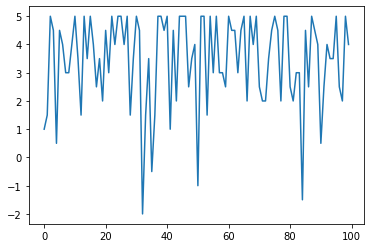

In [195]:
plt.plot(reward_li[-100:])

In [106]:
rate

5

In [101]:
preddict

{tensor(4331406): {70276, 214356, 1391900, 2087086, 2498016},
 tensor(6717064): {2451670, 2465149, 2467158, 2471290, 2473794},
 tensor(1453186): {481794, 572572, 1162759, 1246217, 1593841},
 tensor(13746747): {196585, 197029, 197142, 198279, 2350592},
 tensor(12694617): {217072, 346067, 568990, 1674352, 2426519},
 tensor(12043813): {4266, 4689, 4844, 5437, 5902},
 tensor(7273102): {9770, 16688, 198716, 221579, 2719031},
 tensor(10077243): {1253013, 1569142, 1630879, 1738338, 1824579},
 tensor(13930480): {1856734, 2451670, 2453028, 2456229, 2456819},
 tensor(7836930): {1835140, 1849476, 2452924, 2461402, 2461946},
 tensor(11772633): {215711, 215713, 299006, 317365, 823298},
 tensor(2672556): {9770, 1569295, 1609389, 1616882, 2719031},
 tensor(1181767): {116144, 142283, 522654, 1556227, 1754966},
 tensor(9949838): {1569128, 1569228, 1569232, 1698923, 2438129},
 tensor(7391975): {284339, 678573, 1335215, 1463079, 1709433},
 tensor(13524533): {92502, 194278, 203097, 649014, 671984},
 tenso

In [102]:
reward

tensor([1.])

In [105]:
ratings

1.0

In [104]:
len(memory)

190747

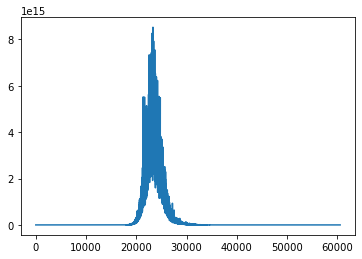

In [192]:
plt.plot(v_loss)

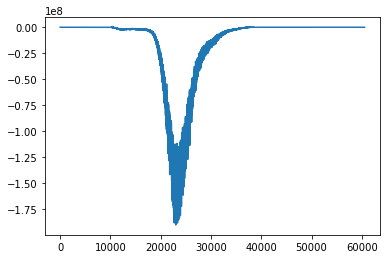

In [193]:
plt.plot(p_loss)

## 6. Testing

In [58]:
#Getting Cosine similarity of recommended items for a particular userid that has been evaluated
# from sklearn.metrics.pairwise import cosine_similarity as cs
# import seaborn as sns

def get_cosine_sim(userid):
    test_pred = test_pred_dict[userid]
    for i,item in enumerate(users_dict[userid]["item"]):
        if item in test_pred:
            print(item,":",users_dict[userid]["rating"][i])

    test_embed = []
    for item in test_pred:
        test_embed.append(np.array(item_embeddings_dict[int(item)]))

    test_embed_array = np.array(test_embed)

    return test_embed_array

test_embed_array = get_cosine_sim(userid_b[0])
ax = sns.heatmap(cs(test_embed_array), linewidth=0.5)
plt.show()


NameError: name 'test_pred_dict' is not defined

In [ ]:
#prediction algorithm
it2 = iter(test_dataloader)
precision = 0
test_pred_dict = dict()
for j in range(len(test_dataloader)-1):  #session 돌리기 : timestamps 내에서 items들 
    first = next(it2)
    item_b,rating_b,size_b,userid_b,idx_b = first['item'],first['rating'],first['size'],first['userid'],first['idx']
    memory[idx_b] = [item[0] for item in item_b]
    state = drrave_state_rep(userid_b,item_b,memory,idx_b)
    count = 0
    test_pred = set()
    for j in range(5):  #policy network5번 돌리기 , 추천 5번 하기
        state_rep =  torch.reshape(state,[-1])
        action_emb = policy_net(state_rep)   # policy_net = actor : items들의 선호도 (rating)
        action = get_action(state,action_emb,userid_b,item_b,test_pred)
        rate = int(users_dict[userid_b[0]]["rating"][action])
        try:
            rating = (int(rate)-3)/2
        except:
            rating = 0
        reward = torch.Tensor((rating,))

        if reward > 0:
            count += 1
            update_memory(memory,int(users_dict[userid_b[0]]["item"][action]),idx_b)
        next_state = drrave_state_rep(userid_b,item_b,memory,idx_b)
        state = next_state
    precision += count/5
    test_pred_dict[userid_b[0]] = test_pred
print("p",precision/(len(test_dataloader)-1))

## 7. Saving and Loading Models

In [ ]:
PATH = '/content/gdrive/My Drive/RLProject/Models/drravepolicy_net.pth'
torch.save(policy_net.state_dict(), PATH)

In [ ]:
value_PATH = '/content/gdrive/My Drive/RLProject/Models/drravevalue_net.pth'
torch.save(value_net.state_dict(), value_PATH)

tpolicy_PATH = '/content/gdrive/My Drive/RLProject/Models/drravetpolicy_net.pth'
torch.save(target_policy_net.state_dict(), tpolicy_PATH)

tvalue_PATH = '/content/gdrive/My Drive/RLProject/Models/drravetvalue_net.pth'
torch.save(target_value_net.state_dict(), tvalue_PATH)

In [ ]:
np.save('/content/gdrive/My Drive/RLProject/Models/train_dataloader',train_dataloader)
np.save('/content/gdrive/My Drive/RLProject/Models/test_dataloader',test_dataloader)

In [ ]:
policy_net = Actor(5500,100,256)
policy_net.load_state_dict(torch.load(PATH))
policy_net.eval()

value_net = Critic(5500,100,256)
value_net.load_state_dict(torch.load(value_PATH))
value_net.eval()

target_policy_net = Actor(5500,100,256)
target_policy_net.load_state_dict(torch.load(tpolicy_PATH))
target_policy_net.eval()

target_value_net = Critic(5500,100,256)
target_value_net.load_state_dict(torch.load(tvalue_PATH))
target_value_net.eval()


In [ ]:
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

train_data = np.load('/content/gdrive/My Drive/RLProject/Models/train_users.npy')

In [ ]:
np.load = np_load_old